# SI608 Final Project Link Prediction 

In [2]:
#import packages
import pandas as pd
import networkx as nx
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

#### Import attribute and co-purchase information

In [3]:
#copurchasing graph with weights as the catergory similarity of the products
fhr = open('amazon_co.edgelist', "rb")
G = nx.read_weighted_edgelist(fhr)
fhr.close()

In [4]:
#graph basic stats
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 366997
Number of edges: 987942
Average degree:   5.3839


In [6]:
#check if graph is directed or undirected 
G.is_directed()

False

In [8]:
#manually checking degree calculation since it is a undirected graph 
2*G.number_of_edges() / float(G.number_of_nodes())

5.38392411927073

In [148]:
#import metadata to get the more node information
meta = pd.read_csv('meta.csv', usecols=['ASIN','Id','Copurchased', 'Group','Categories', 'SalesRank', 'TotalReviews', 'AvgRating', 'DegreeCentrality', 'ClusteringCoeff'] )

In [149]:
meta.head()

,ASIN,Id,Categories,Group,Copurchased,SalesRank,TotalReviews,AvgRating,DegreeCentrality,ClusteringCoeff
0,0771044445,0,NaN,NaN,NaN,0,0,0.0,0,0.00
1,0827229534,1,subject religion sermon book preach christian ...,Book,0804215715 156101074X 0687023955 0687074231 08...,396585,2,5.0,8,0.80
2,0738700797,2,wicca earth subject religion base book witchcr...,Book,0738700827 1567184960 1567182836 0738700525 07...,168596,12,4.5,9,0.85
3,0486287785,3,home subject garden book craft general hobbi,Book,NaN,1270652,1,5.0,0,0.00
4,0842328327,4,bibl testament live applic life new studi gene...,Book,0842328130 0842330313 0842328610 0842328572,631289,1,4.0,6,0.79


In [197]:
#change categories that are NaN to none
meta['Categories'].fillna('none', inplace=True)

In [12]:
#obtain subset of dataframe with ASIN, group, SalesRank, and AvgRating
meta_att=meta[['ASIN', 'Group', 'SalesRank', 'AvgRating']]
node_attr = meta_att.set_index('ASIN').to_dict('index')
nx.set_node_attributes(G, node_attr)

In [13]:
#sanity check
G.nodes['0827229534']

{'Group': 'Book', 'SalesRank': 396585, 'AvgRating': 5.0}

#### Obtain edgelist for existing links

In [123]:
#obtain co_purchased edgelist
df_co = nx.to_pandas_edgelist(G)

In [124]:
#create row "connection" set to 1 
df_co['connection']=1
#create tuple of source and target to get network attributes
df_co['nodes']=list(zip(df_co.source, df_co.target))

#### Generate list of non-existing co-purchases

In [125]:
#obtain list ppf co existing connections and values
c=pd.Series(df_co.connection.values,index=df_co.nodes).to_dict()

#obtain list of nodes
nodes=list(G.nodes)

In [126]:
#function to create missing edges for testing purposes
import random

def missing_random(exist_con, nodes, num):
    
    missing_edges = set([])
    while (len(missing_edges)<num):
        a=str(random.choice(nodes))
        b=str(random.choice(nodes))
        #check if edge exist between the two nodes, if not set to 0
        conn=exist_con.get((a,b),0)
        if conn==0 and a!=b:
            missing_edges.add((a,b))
        else:
            continue   
   
    return missing_edges

In [127]:
#generate 500,000 missing connections
missing_generated=missing_random(c, nodes, 500000)

In [199]:
#categories for nodes
node_cat = dict(zip(meta.ASIN, meta.Categories))

In [208]:
#calculate the 'weight' indicating the similarity of categories for the items
missing_sim=[]

for a,b in missing_generated:
#     print(b)
    similarity = 0
    n1 = set((node_cat[a].split()))
    n2 = set((node_cat[b]).split())
    n1In2 = n1 & n2     # intersection 
    n1Un2 = n1 | n2     # union 
    if(len(n1Un2)) > 0:
        similarity = round(len(n1In2)/len(n1Un2), 2)
    missing_sim.append(similarity)

In [209]:
#create a dataframe from the missing generated
df_miss=pd.DataFrame(missing_generated, columns=['source', 'target'])
#make connection equal to 0 and and weight equal to the similarity scores 
df_miss['weight']=missing_sim
df_miss['connection']=0
df_miss['nodes']=list(zip(df_miss.source, df_miss.target))

In [210]:
df_miss.shape, df_co.shape

((500000, 5), (987942, 8))

#### Obtain Network Stats for links to non-existing links

In [212]:
#obtain network stats for the pair of nodes

#add jaccard_coefficent to network dataframe, will be 0 for non-connecting nodes
df_miss['jac_coe']=0

#add resource allocation to network dataframe, will be 0 for non-connecting nodes
df_miss['resource_a'] = 0

#add preferential attachment to network dataframe
pa = nx.preferential_attachment(G, ebunch=df_miss['nodes'].tolist())
pa = pd.DataFrame(pa)
df_miss['pref_a'] = pa[2]


#### Obtain Network Stats for links to existing links

In [131]:
#obtain network stats for the pair of nodes

#add jaccard_coefficent to network dataframe
jc=nx.jaccard_coefficient(G, ebunch=df_co['nodes'].tolist())
jc = pd.DataFrame(jc)
df_co['jac_coe']=jc[2]

#add resource allocation to network dataframe
ra = nx.resource_allocation_index(G, ebunch=df_co['nodes'].tolist())
ra = pd.DataFrame(ra)
df_co['resource_a'] = ra[2]

#add preferential attachment to network dataframe
pa = nx.preferential_attachment(G, ebunch=df_co['nodes'].tolist())
pa = pd.DataFrame(pa)
df_co['pref_a'] = pa[2]


#### Combine dataframes

In [213]:
#combine both dataframes
df_all=df_miss.append(df_co, ignore_index=True)

In [223]:
#add the salesrank to dataframe
sale_cat = dict(zip(meta.ASIN, meta.SalesRank))

In [228]:
total_rank=[]
all_nodes=df_all['nodes'].tolist()

for i in all_nodes:
    sale_add=sale_cat[i[0]]+sale_cat[i[1]]
    total_rank.append(sale_add)

df_all['sale_rank']=total_rank

In [230]:
df_all.shape

(1487942, 9)

In [229]:
df_all.head()

,source,target,weight,connection,nodes,jac_coe,resource_a,pref_a,sale_rank
0,0375409378,B00008OM2C,0.06,0,"(0375409378, B00008OM2C)",0.0,0.0,5,814862
1,0440412862,0399230211,0.27,0,"(0440412862, 0399230211)",0.0,0.0,30,743650
2,185149037X,0814405185,0.14,0,"(185149037X, 0814405185)",0.0,0.0,9,940733
3,0671670476,1858285542,0.12,0,"(0671670476, 1858285542)",0.0,0.0,20,1513131
4,052100926X,0312206399,0.18,0,"(052100926X, 0312206399)",0.0,0.0,18,326816


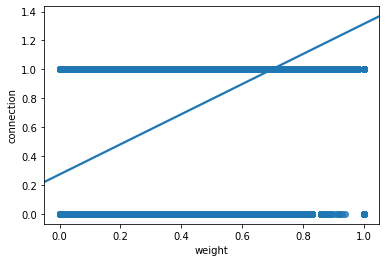

In [242]:
#regression plot
ax = sns.regplot(x="weight", y="connection", data=df_all)

> I selected these features for the group of nodes because they highlight the similarity of distance and who they attach to, which can be good predictors for future links

#### Baseline Link Prediction Models with only SalesRank

In [239]:
#create test train spilt
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_all[['sale_rank']],df_all['connection'].astype(int),stratify=df_all['connection'].astype(int),random_state=0)

In [232]:
#logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg = LogisticRegression(solver='lbfgs').fit(X_train, y_train)
lr_pred = logreg.predict(X_test)

print('Logistic Regression AUC ROC Score: ', metrics.roc_auc_score(y_test,lr_pred))
print('Logistic Regression Accuracy Score: ', metrics.accuracy_score(y_test,lr_pred))

Logistic Regression AUC ROC Score:  0.5
Logistic Regression Accuracy Score:  0.6639658481770819


In [240]:
#gbc
from sklearn.ensemble import GradientBoostingClassifier

gbc=GradientBoostingClassifier().fit(X_train, y_train)
gbc_pred=gbc.predict(X_test)

print('GBC Classifier AUC ROC Score: ', metrics.roc_auc_score(y_test,gbc_pred))
print('GBC Classifier Accuracy Score: ', gbc.score(X_test, y_test))

GBC Classifier AUC ROC Score:  0.5122523322617476
GBC Classifier Accuracy Score:  0.6653637502486652


In [241]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=0, n_jobs=-1).fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

print('RFC Classifier AUC ROC Score: ', metrics.roc_auc_score(y_test,rfc_pred))
print('RFC Classifier Accuracy Score: ', rfc.score(X_test, y_test))

RFC Classifier AUC ROC Score:  0.5285713148437563
RFC Classifier Accuracy Score:  0.583798852644992


#### Link Prediction Models with network attributes

In [233]:
#create test train spilt
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_all[['jac_coe', 'resource_a','pref_a', 'weight', 'sale_rank' ]],df_all['connection'].astype(int),stratify=df_all['connection'].astype(int),random_state=0)

In [234]:
#logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg = LogisticRegression(solver='lbfgs').fit(X_train, y_train)
lr_pred = logreg.predict(X_test)

print('Logistic Regression AUC ROC Score: ', metrics.roc_auc_score(y_test,lr_pred))
print('Logistic Regression Accuracy Score: ', metrics.accuracy_score(y_test,lr_pred))

Logistic Regression AUC ROC Score:  0.6382381352465323
Logistic Regression Accuracy Score:  0.7276107165323427


In [238]:
#gbc
from sklearn.ensemble import GradientBoostingClassifier

gbc=GradientBoostingClassifier().fit(X_train, y_train)
gbc_pred=gbc.predict(X_test)

print('GBC Classifier AUC ROC Score: ', metrics.roc_auc_score(y_test,gbc_pred))
print('GBC Classifier Accuracy Score: ', gbc.score(X_test, y_test))

GBC Classifier AUC ROC Score:  0.9496455169118898
GBC Classifier Accuracy Score:  0.9503556585462893


In [236]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=0, n_jobs=-1).fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

print('RFC Classifier AUC ROC Score: ', metrics.roc_auc_score(y_test,rfc_pred))
print('RFC Classifier Accuracy Score: ', rfc.score(X_test, y_test))

RFC Classifier AUC ROC Score:  0.931515150300017
RFC Classifier Accuracy Score:  0.9360836160500664


In [237]:
#Determine Important Features
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head()

,importance
weight,0.378505
resource_a,0.247455
jac_coe,0.161392
sale_rank,0.146720
pref_a,0.065929
